In [22]:
from matplotlib import pyplot as plt
from torch import nn
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
from torchvision import datasets
from PIL import Image 
import os
import torch.nn.functional as F
from tqdm import tqdm

In [23]:
train_videos_path = r'C:\Users\mihai\Desktop\forehand-analysis\images_dataset\train'
test_videos_path = r'C:\Users\mihai\Desktop\forehand-analysis\images_dataset\test'

In [24]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((391, 422)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_videos_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = datasets.ImageFolder(root=test_videos_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [25]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 14
    Root location: C:\Users\mihai\Desktop\forehand-analysis\images_dataset\train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(391, 422), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

torch.Size([1, 391, 422])


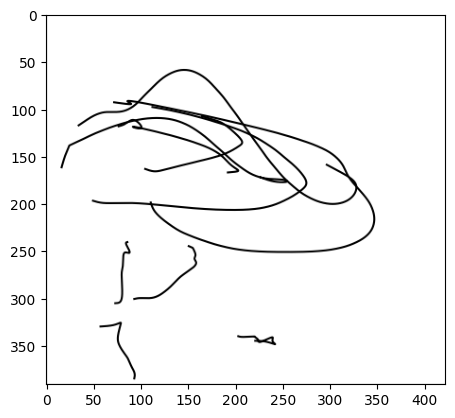

In [26]:
img, label = train_dataset[0]
img_height = img.shape[1]
img_width = img.shape[2]
print(img.shape)
plt.imshow(img.numpy().reshape(img_height, img_width), cmap='gray')

In [27]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(1, 16, 3) 
        self.layer2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.layer3 = nn.Linear(319488, 128)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.layer1(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = F.relu(self.layer2(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = F.relu(self.layer3(x))
        return self.fc(x)

In [28]:
model = ConvNet()

In [29]:
model(img.reshape(1,1,img_height,img_width)) # dodajemo batch_size=1

tensor([[0.0276]], grad_fn=<AddmmBackward0>)

In [30]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
device = 'gpu' if torch.cuda.is_available() else 'cpu'
model.to(device)

ConvNet(
  (layer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer3): Linear(in_features=319488, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [31]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train() 
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y = y.view(-1, 1).float()
        #print('y: ', y, ' : ', y.shape)
        preds = model(X)
        loss = loss_fn(preds, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [32]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval() 
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.view(-1, 1).float()
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            print(outputs)

            if len(outputs.shape) == 2: # accuracy - dve klase
                preds = outputs > 0 # (izlazi > 0 -> klasa 1, izlazi <= 0 -> klasa 0)
                print(preds)
                num_same += sum(preds == y).item()
            else: # accuracy - vise klasa
                _, indices = torch.max(outputs, 1) # maks po dimenziji 1 jer je outputs.shape = (batch_size, num_classes)
                num_same += sum(indices == y).item()
        print(f'Average loss: {total_loss / len(dataloader.dataset)}')
        print(f'Accuracy: {num_same / len(dataloader.dataset)}')

In [33]:
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    train_loop(train_loader, model, loss_fn, optimizer, device)
    test_loop(test_loader, model, loss_fn, device)

 10%|████████▎                                                                          | 1/10 [00:05<00:46,  5.12s/it]

tensor([[-0.0924]])
tensor([[False]])
tensor([[-0.0768]])
tensor([[False]])
tensor([[-0.0785]])
tensor([[False]])
tensor([[-0.0826]])
tensor([[False]])
tensor([[-0.0977]])
tensor([[False]])
tensor([[-0.0808]])
tensor([[False]])
Average loss: 0.6929394801457723
Accuracy: 0.5


 20%|████████████████▌                                                                  | 2/10 [00:09<00:35,  4.40s/it]

tensor([[0.0239]])
tensor([[True]])
tensor([[0.0449]])
tensor([[True]])
tensor([[0.0080]])
tensor([[True]])
tensor([[-0.0320]])
tensor([[False]])
tensor([[0.0079]])
tensor([[True]])
tensor([[0.0082]])
tensor([[True]])
Average loss: 0.6854942838350931
Accuracy: 0.6666666666666666


 30%|████████████████████████▉                                                          | 3/10 [00:12<00:29,  4.18s/it]

tensor([[0.0212]])
tensor([[True]])
tensor([[0.0307]])
tensor([[True]])
tensor([[0.0658]])
tensor([[True]])
tensor([[-0.0861]])
tensor([[False]])
tensor([[0.1351]])
tensor([[True]])
tensor([[0.0095]])
tensor([[True]])
Average loss: 0.6698850691318512
Accuracy: 0.6666666666666666


 40%|█████████████████████████████████▏                                                 | 4/10 [00:16<00:24,  4.07s/it]

tensor([[0.2553]])
tensor([[True]])
tensor([[0.3232]])
tensor([[True]])
tensor([[0.3506]])
tensor([[True]])
tensor([[0.4928]])
tensor([[True]])
tensor([[-0.1628]])
tensor([[False]])
tensor([[0.8883]])
tensor([[True]])
Average loss: 0.6110302607218424
Accuracy: 0.6666666666666666


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:20<00:19,  3.99s/it]

tensor([[0.4604]])
tensor([[True]])
tensor([[1.6942]])
tensor([[True]])
tensor([[0.3207]])
tensor([[True]])
tensor([[0.8436]])
tensor([[True]])
tensor([[0.1662]])
tensor([[True]])
tensor([[-1.2635]])
tensor([[False]])
Average loss: 0.5341385801633199
Accuracy: 0.6666666666666666


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:24<00:15,  3.95s/it]

tensor([[0.5956]])
tensor([[True]])
tensor([[1.1069]])
tensor([[True]])
tensor([[2.3831]])
tensor([[True]])
tensor([[-1.8775]])
tensor([[False]])
tensor([[0.3689]])
tensor([[True]])
tensor([[0.2720]])
tensor([[True]])
Average loss: 0.5019580461084843
Accuracy: 0.6666666666666666


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:28<00:11,  3.92s/it]

tensor([[1.1850]])
tensor([[True]])
tensor([[0.1935]])
tensor([[True]])
tensor([[2.7747]])
tensor([[True]])
tensor([[-2.5422]])
tensor([[False]])
tensor([[0.1004]])
tensor([[True]])
tensor([[0.5408]])
tensor([[True]])
Average loss: 0.4735697948684295
Accuracy: 0.6666666666666666


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:32<00:07,  3.92s/it]

tensor([[0.8606]])
tensor([[True]])
tensor([[4.0488]])
tensor([[True]])
tensor([[-2.2645]])
tensor([[False]])
tensor([[2.1085]])
tensor([[True]])
tensor([[1.4775]])
tensor([[True]])
tensor([[1.0264]])
tensor([[True]])
Average loss: 0.5998535118997097
Accuracy: 0.6666666666666666


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:36<00:03,  3.89s/it]

tensor([[1.2443]])
tensor([[True]])
tensor([[1.7433]])
tensor([[True]])
tensor([[-2.4587]])
tensor([[False]])
tensor([[2.3551]])
tensor([[True]])
tensor([[4.4855]])
tensor([[True]])
tensor([[1.0089]])
tensor([[True]])
Average loss: 0.649466814318051
Accuracy: 0.6666666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  4.00s/it]

tensor([[4.4640]])
tensor([[True]])
tensor([[-2.9165]])
tensor([[False]])
tensor([[1.6108]])
tensor([[True]])
tensor([[2.2587]])
tensor([[True]])
tensor([[1.0822]])
tensor([[True]])
tensor([[0.8000]])
tensor([[True]])
Average loss: 0.616920760832727
Accuracy: 0.6666666666666666
